# Part 1 Efficient COCO

Correlation between x and y: 0.007379177131576432
COCO value is: 0.0033296301176721165
Correlation between f(x) and g(y): 0.9504299742787753


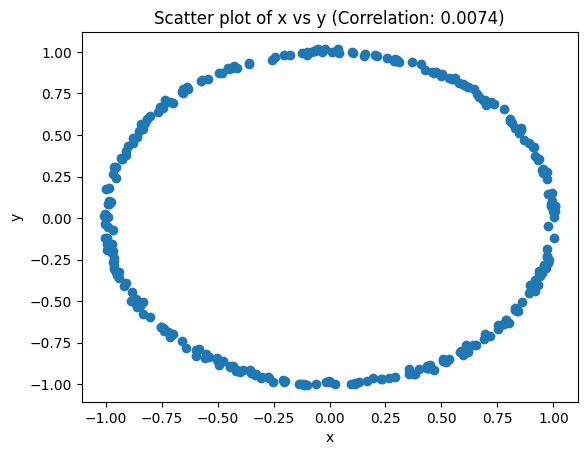

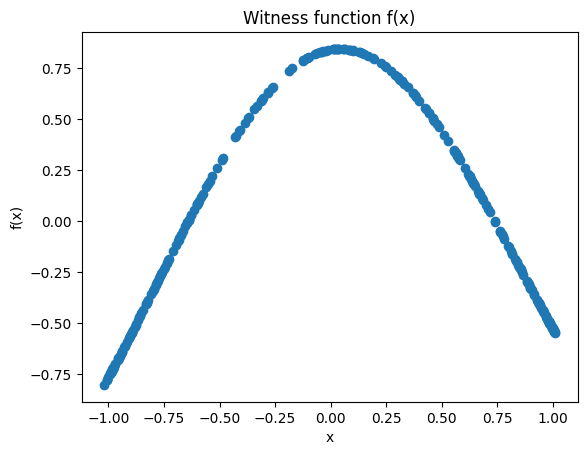

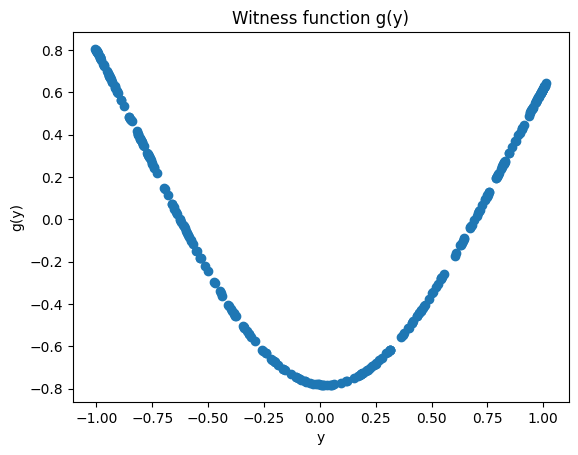

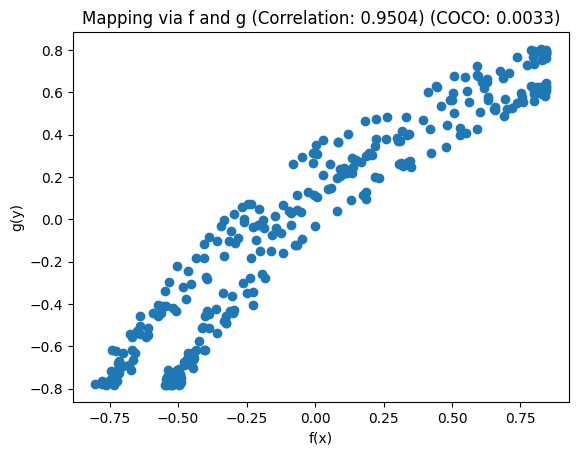

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

def gaussian_kernel(x1, x2, sigma):
    """Compute the Gaussian kernel between x1 and x2."""
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(1, -1)
    sq_dists = (x1 - x2) ** 2
    return np.exp(-sq_dists / (2 * sigma ** 2))

def generate_data(num, seed1=None, seed2=None):
    """Generate data."""
    if seed1 is not None:
        np.random.seed(seed1)
    t = np.random.uniform(0, 2 * np.pi, num)
    n1 = np.random.normal(0, 0.01, num)
    if seed2 is not None:
        np.random.seed(seed2)
    n2 = np.random.normal(0, 0.01, num)
    x = np.sin(t) + n1
    y = np.cos(t) + n2
    return x, y

def incomplete_cholesky(matrix, eta=1e-6, max_rank=None):
    """Perform incomplete Cholesky decomposition with low-rank approximation."""
    num = matrix.shape[0]
    R = np.zeros((num, num))
    d = np.diag(matrix).copy()
    j = 0

    while True:
        a = np.max(d)
        if a <= eta or (max_rank is not None and j >= max_rank):
            break
        i_j = np.argmax(d)
        nu_j = np.sqrt(a)
        for i in range(num):
            if j == 0:
                R[j, i] = matrix[i_j, i] / nu_j
            else:
                R[j, i] = (matrix[i_j, i] - np.dot(R[:j, i], R[:j, i_j])) / nu_j
            d[i] -= R[j, i] ** 2
        j += 1

    R = R[:j, :]  # R is of shape (j, num)
    Z = R.T       # Z is of shape (num, j)
    return Z

def solve_coco(K, L, eta=1e-6, max_rank=None):
    """Solve the COCO problem with low-rank approximations."""
    num = K.shape[0]
    H = np.eye(num) - (1 / num) * np.ones((num, num))

    # Apply incomplete Cholesky decomposition to K and L
    R = incomplete_cholesky(K, eta=eta, max_rank=max_rank)
    Q = incomplete_cholesky(L, eta=eta, max_rank=max_rank)

    # Center the decomposed matrices
    R_tilde = H @ R
    Q_tilde = H @ Q
    
    C_RQ = R_tilde.T @ Q_tilde
    C_RR = R_tilde.T @ R_tilde
    C_QQ = Q_tilde.T @ Q_tilde

    # Compute the matrices for the generalized eigenvalue problem
    A_upper = np.hstack([np.zeros_like(C_RQ), (1 / num) * C_RQ  ])
    A_lower = np.hstack([(1 / num) * C_RQ.T  , np.zeros_like(C_RQ)])
    A = np.vstack([A_upper, A_lower])

    B_upper = np.hstack([C_RR, np.zeros_like(C_RR)])
    B_lower = np.hstack([np.zeros_like(C_QQ), C_QQ])
    B = np.vstack([B_upper, B_lower])

    # Solve the generalized eigenvalue problem A v = lambda B v
    eigvals, eigvecs = scipy.linalg.eigh(A, B)

    # Extract the eigenvector corresponding to the largest eigenvalue
    idx = np.argmax(np.real(eigvals))
    eigvec = eigvecs[:, idx].real
    u = eigvec[:R_tilde.shape[1]] @ R_tilde.T
    v = eigvec[R_tilde.shape[1]:] @ Q_tilde.T

    return u, v, eigvals[idx].real

def apply_witness_functions(u, v, x_train, y_train, x_test, y_test, sigma):
    """Apply witness functions to test data."""
    # Compute kernels between training and test data
    K_train_test = gaussian_kernel(x_train, x_test, sigma)
    L_train_test = gaussian_kernel(y_train, y_test, sigma)

    # Center the kernels
    mean_K_train = np.mean(K_train_test, axis=0)
    mean_K_test = np.mean(K_train_test, axis=1)
    mean_K = np.mean(K_train_test)
    K_train_test_centered = K_train_test - mean_K_train - mean_K_test[:, np.newaxis] + mean_K

    mean_L_train = np.mean(L_train_test, axis=0)
    mean_L_test = np.mean(L_train_test, axis=1)
    mean_L = np.mean(L_train_test)
    L_train_test_centered = L_train_test - mean_L_train - mean_L_test[:, np.newaxis] + mean_L

    # Compute projections onto the low-rank basis
    f = K_train_test_centered.T @ u
    g = L_train_test_centered.T @ v

    return f, g

def compute_correlation(a, b):
    """Compute the correlation between two arrays."""
    corr_matrix = np.corrcoef(a, b)
    return corr_matrix[0, 1]

def plot_scatter(x, y, xlabel, ylabel, title, filename=None):
    """Plot scatter plot of x and y."""
    plt.figure()
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

def plot_results(
    x_train, y_train, x_test, y_test, corr_xy, f, g, corr_fg, coco_value
):
    """Plot the results."""
    plot_scatter(
        x_train,
        y_train,
        'x',
        'y',
        f'Scatter plot of x vs y (Correlation: {corr_xy:.4f})',
        filename='x_y.png',
    )

    plot_scatter(
        x_test, f, 'x', 'f(x)', 'Witness function f(x)', filename='fx_coco.png'
    )

    plot_scatter(
        y_test, g, 'y', 'g(y)', 'Witness function g(y)', filename='gy_coco.png'
    )

    plot_scatter(
        f,
        g,
        'f(x)',
        'g(y)',
        f'Mapping via f and g (Correlation: {corr_fg:.4f}) (COCO: {coco_value:.4f})',
        filename='fx_gy_coco.png',
    )

def main():
    num = 300
    sigma = 1
    eta = 1e-6
    max_rank = 10 

    # Generate data
    x_train, y_train = generate_data(num, seed1=123, seed2=234)
    corr_xy = compute_correlation(x_train, y_train)
    print("Correlation between x and y:", corr_xy)

    # Compute kernel matrices K and L
    K = gaussian_kernel(x_train, x_train, sigma)
    L = gaussian_kernel(y_train, y_train, sigma)

    # Solve the COCO problem
    u, v, coco_value = solve_coco(K, L, eta=eta, max_rank=max_rank)
    print("COCO value is:", coco_value)

    # Generate test data
    x_test, y_test = generate_data(num, seed1=345, seed2=456)

    # Apply witness functions to test data
    f, g = apply_witness_functions(
        u, v, x_train, y_train, x_test, y_test, sigma
    )
    corr_fg = compute_correlation(f, g)
    print("Correlation between f(x) and g(y):", corr_fg)

    # Plot results
    plot_results(
        x_train, y_train, x_test, y_test, corr_xy, f, g, corr_fg, coco_value
    )

if __name__ == "__main__":
    main()


# Part 2 Regularized KCCA

Correlation between x and y: 0.007379177131576432
CCA value is: 0.003328257099409248
Correlation between f(x) and g(y): 0.9984651723908056


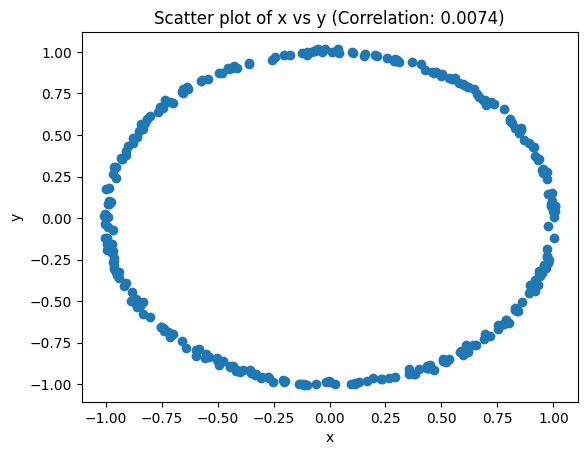

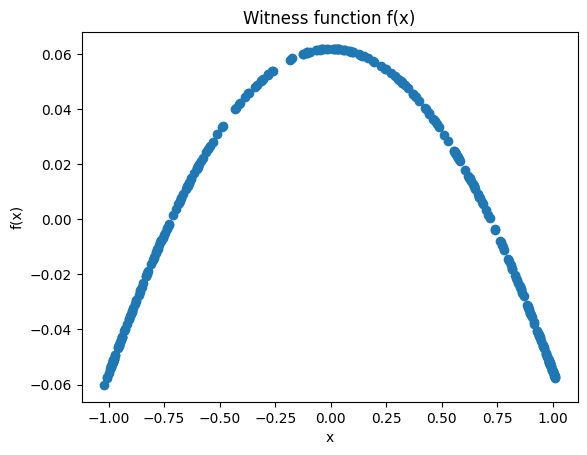

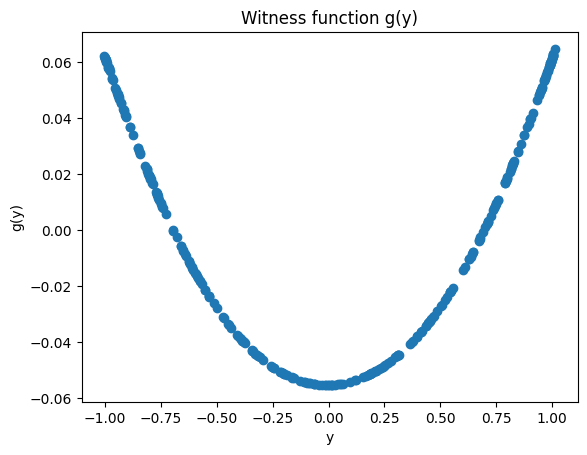

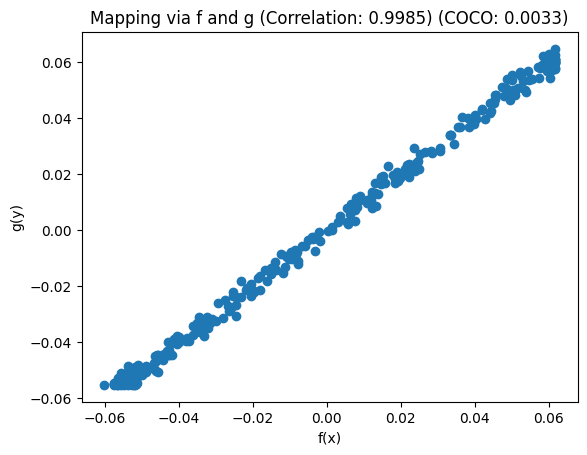

In [2]:
def block_diag(*arrs):
    """Create a block diagonal matrix from provided arrays."""
    shapes = np.array([a.shape for a in arrs])
    out = np.zeros(np.sum(shapes, axis=0), dtype=arrs[0].dtype)
    r, c = 0, 0
    for arr in arrs:
        rows, cols = arr.shape
        out[r:r + rows, c:c + cols] = arr
        r += rows
        c += cols
    return out


def solve_cca(K, L):
    """Solve the CCA problem."""
    num = K.shape[0]
    H = np.eye(num) - (1 / num) * np.ones((num, num))
    K_tilde = H @ K @ H
    L_tilde = H @ L @ H

    A = np.zeros((2 * num, 2 * num))
    A[0:num, num:] = (1 / num) * K_tilde @ L_tilde
    A[num:, 0:num] = (1 / num) * L_tilde @ K_tilde
    
    kappa = 1e-6
    # Approximation:
    #
    # We aim to approximate the expression:
    #     K_tilde^2 + kappa * K_tilde
    # as:
    #     (K_tilde + (num * kappa) / 2 * I)^2
    #
    # Expanding the right-hand side:
    #     (K_tilde + (num * kappa) / 2 * I)^2
    #     = K_tilde^2 + num * kappa / 2 * K_tilde * I + num * kappa / 2 * I * K_tilde + (num * kappa / 2)^2 * I^2
    #     = K_tilde^2 + num * kappa * K_tilde + (num * kappa / 2)^2 * I
    #
    # To match the left-hand side (K_tilde^2 + kappa * K_tilde), we set:
    #     num * kappa * K_tilde ≈ kappa * K_tilde
    # which implies that the additional regularization term:
    #     (num * kappa / 2)^2 * I
    # is negligible or can be absorbed into the regularization.
    #
    # Therefore, the approximation holds under the assumption that:
    #     (num * kappa / 2)^2 * I is small compared to other terms.
    #
    # This allows us to write:
    #     K_tilde^2 + kappa * K_tilde ≈ (K_tilde + (num * kappa) / 2 * I)^2

    # Apply the approximation to K_tilde and L_tilde
    B11 = np.linalg.matrix_power(K_tilde + ((num * kappa) / 2) * np.eye(num), 2)
    B22 = np.linalg.matrix_power(L_tilde + ((num * kappa) / 2) * np.eye(num), 2)
    B = block_diag(B11, B22)

    # Solve the generalized eigenvalue problem A v = lambda B v
    eigvals, eigvecs = scipy.linalg.eigh(A, B)

    # Select the largest eigenvalue and corresponding eigenvector
    idx = np.argmax(eigvals.real)
    eigvec = eigvecs[:, idx].real

    alpha = eigvec[:num]
    beta = eigvec[num:]
    return alpha, beta, eigvals[idx].real


def apply_witness_functions(alpha, beta, x_train, y_train, x_test, y_test, sigma):
    """Apply witness functions to test data."""
    # Compute kernels between training and test data
    K_train_test = gaussian_kernel(x_train, x_test, sigma)
    L_train_test = gaussian_kernel(y_train, y_test, sigma)

    # Center the kernels
    mean_K_train = np.mean(K_train_test, axis=0)
    mean_K_test = np.mean(K_train_test, axis=1)
    mean_K = np.mean(K_train_test)
    K_train_test_centered = K_train_test - mean_K_train - mean_K_test[:, np.newaxis] + mean_K

    mean_L_train = np.mean(L_train_test, axis=0)
    mean_L_test = np.mean(L_train_test, axis=1)
    mean_L = np.mean(L_train_test)
    L_train_test_centered = L_train_test - mean_L_train - mean_L_test[:, np.newaxis] + mean_L

    # Compute projections onto the low-rank basis
    f = K_train_test_centered.T @ alpha 
    g = L_train_test_centered.T @ beta

    return f, g


def plot_results(x_train, y_train, x_test, y_test, corr_xy, f, g, corr_fg, cca_value):
    """Plot the results."""
    plot_scatter(
        x_train, y_train, 'x', 'y',
        f'Scatter plot of x vs y (Correlation: {corr_xy:.4f})'
    )

    plot_scatter(
        x_test, f, 'x', 'f(x)', 'Witness function f(x)', filename='fx_cca.png'
    )

    plot_scatter(
        y_test, g, 'y', 'g(y)', 'Witness function g(y)', filename='gy_cca.png'
    )

    plot_scatter(
        f, g, 'f(x)', 'g(y)',
        f'Mapping via f and g (Correlation: {corr_fg:.4f}) (COCO: {cca_value:.4f})',
        filename='fg_mapping.png'
    )


def main():
    num = 300
    sigma = 1

    x_train, y_train = generate_data(num, seed1=123, seed2=234)
    corr_xy = compute_correlation(x_train, y_train)
    print("Correlation between x and y:", corr_xy)

    K = gaussian_kernel(x_train, x_train, sigma)
    L = gaussian_kernel(y_train, y_train, sigma)
    alpha, beta, cca_value = solve_cca(K, L)
    print("CCA value is:", cca_value)

    x_test, y_test = generate_data(num, seed1=345, seed2=456)
    f, g = apply_witness_functions(alpha, beta, x_train, y_train, x_test, y_test, sigma)
    corr_fg = compute_correlation(f, g)
    print("Correlation between f(x) and g(y):", corr_fg)

    plot_results(x_train, y_train, x_test, y_test, corr_xy, f, g, corr_fg, cca_value)


if __name__ == "__main__":
    main()


In [ ]:
import 